There are several Core processes that are used to build the RGCN model.

1. **Data Preparation**:
   - Load and preprocess the knowledge graph data.
   - Create training, validation, and test sets.
   - Build out Node and Edge Data Loaders
   - Build Out relationship Graph

2. **Model Architecture**:
   - Define the RGCN model structure.
   - Specify the number of layers, hidden dimensions, and output dimensions.

3. **Training**:
   - Implement the training loop.
   - Use appropriate loss functions and optimizers.

In [8]:
import pandas as pd
import os

os.chdir('/Users/cosmodenny/zavmo-api')

In [41]:
ofqual_data = pd.read_csv('docs/nos-ofqual/ofqual_20250127-v2.csv.zip')
nos_data = pd.read_excel('docs/nos-ofqual/latest_nos_data.xlsx')
nos_data.to_csv('docs/nos-ofqual/latest_nos_data.csv', index=False)
nos_data = pd.read_csv('docs/nos-ofqual/latest_nos_data.csv')
nos_ssa_data = pd.read_csv('docs/nos-ofqual/NOS_Data_w_SSA_Industry.csv')



In [31]:
import pandas as pd
pd.set_option('display.max_colwidth', None)  # Show full column width
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.width', None) 

In [32]:
ofqual_data.columns

Index(['unit_key', 'owner_organisation_name', 'title', 'unit_ssa',
       'learning_outcomes', 'ofqual_id', 'level_str', 'level', 'text'],
      dtype='object')

In [36]:
ofqual_learning_outcomes_eg = ofqual_data['learning_outcomes'][:2]
print(ofqual_learning_outcomes_eg)

0                                                                                                                                Know about engineering materials, Know how to use engineering tools
1    Work safely, Know about cooling systems, Know how to use antifreeze, Be able to pressure test a cooling system, Know about engine lubrication systems, Be aware of environmental considerations
Name: learning_outcomes, dtype: object


In [35]:
ofqual_text_eg = ofqual_data['text'][:2]
print(ofqual_text_eg)

0                                                                                                                                                 **500/4242/7**\nTitle: Introduction to Engineering Equipment and Materials (Level 1)\nSector Subject Area: 04.3 Transportation operations and maintenance\nOrganisation: Skills and Education Group Awards\nLearning Outcomes:\n\nKnow about engineering materials, Know how to use engineering tools
1    **500/4242/7**\nTitle: Introduction to Engine Liquid Cooling and Engine Lubrication Systems (Level 1)\nSector Subject Area: 04.3 Transportation operations and maintenance\nOrganisation: Skills and Education Group Awards\nLearning Outcomes:\n\nWork safely, Know about cooling systems, Know how to use antifreeze, Be able to pressure test a cooling system, Know about engine lubrication systems, Be aware of environmental considerations
Name: text, dtype: object


Hmm ok so looking at this i think that we might be able to further make this data slighly better by adding in a level of granularity to the learning outcomes, e.g learning outcomes, then learning outcome 1.1, 1.2, 1.3 etc.

In [42]:
nos_data.columns

Index(['nos_title', 'urn', 'suites', 'occupations', 'soc', 'developed_by',
       'approved_on', 'web_link', 'pdf_link'],
      dtype='object')

In [44]:
nos_suites_eg = nos_data['suites'][:2]
print(nos_suites_eg)
nos_pdf_eg = nos_data['pdf_link'][:2]
print(nos_pdf_eg)



0    Abnormal Load Escorting
1    Abnormal Load Escorting
Name: suites, dtype: object
0    https://files.ukstandards.org.uk/pdfs/SFL240TemplateF2012v2.pdf
1      https://files.ukstandards.org.uk/pdfs/SFL241TemplateF2012.pdf
Name: pdf_link, dtype: object


Ok so the links then provide the following information:
Performance Criteria
P1-Pn
Knowledge and Understanding
K1-Kn

Essentially in my head we are trying to create a tree slide of information right.

You Have:
SSA -> Sub_SSA -> Industry -> NOS -> Competency -> Knowledge and Understanding -> Performance Criteria
                               |        |
                             OFQUAL -> Unit -> Learning Outcome -> Knowledge and Understanding -> Performance Criteria

I'm going to get an example OFQUAL from our Agent to find one that we can use to build an example tree slide of information.

In [39]:
nos_ssa_data.columns

Index(['nos_id', 'NOS_Industry', 'title', 'text', 'OFQUAL_SSA',
       'Additional OFQUAL_SSA', 'Additional_OFQUAL_SSA.2',
       'Additional_OFQUAL_SSA.3', 'Additional_OFQUAL_SSA.4',
       'Additional_OFQUAL_SSA.5', 'Additional_OFQUAL_SSA.6'],
      dtype='object')

Ok in nos_data we have nos_id, Nos_text, nos_industry, ofqual_ssa (this is a sector subject area(ssa), that at a surface level
maps our ofqual and nos together, there are 50 total SSAs and a couple hundred nos industries, ideally we want to create a tree of parent child grandchil subnode for industry then also have some sort of mapping based off competency and ofqual unit, could be some sort of similarity and then overtime based off maping score we can build relationships) 

so essentially we can map node_types based off OFQUAL, NOS, SSA, Sub_SSA, Industry, Competency

In [16]:
node_types = {
    'NOS': ['nos_id', 'nos_text'],  # NOS units
    'OFQUAL': ['ofqual_id', 'ofqual_text'],  # OFQUAL units
    'SSA': ['ssa_code', 'ssa_description'],  # Sector Subject Area Integar e.g 5 Construction, Planning and the Built Environment
    'Sub_SSA': ['sub_ssa_code', 'sub_ssa_description'],  # Sub Sector Subject Areas, e.g 5.1 - Architecture
    'Unit': ['unit_id', 'unit_description'],  # Unit of Qualification
    'Learning_Outcome': ['learning_outcome_id', 'learning_outcome_description'],  # Learning Outcome from OFQUAL Unit
    'Performance_Criteria': ['performance_criteria_id', 'performance_criteria_description'],  # Performance Criteria from NOS which we try to map to OFQUAL
    'Knowledge_and_Understanding': ['knowledge_and_understanding_id', 'knowledge_and_understanding_description'],  # Knowledge and Understanding from NOS That we try to map to OFQUAL
    'Industry': ['industry_id', 'industry_name'],  # Industry categories
    'Competency': ['comp_id', 'comp_description']  # Competencies extracted from text
}

edge_types = {
    ('SSA', 'parent_of', 'Sub_SSA'),
    ('NOS', 'belongs_to', 'Sub_SSA'),
    ('OFQUAL', 'belongs_to', 'Sub_SSA'),
    ('NOS', 'belongs_to', 'Industry'),
    ('Industry', 'belongs_to', 'Sub_SSA'),
    ('NOS', 'requires', 'Competency'),
    ('OFQUAL', 'requires', 'Competency'),
    ('NOS', 'similar_to', 'OFQUAL'),  # Similarity-based mapping
    ('Competency', 'similar_to', 'Competency'),  # Competency relationships
    ('Unit', 'similar_to', 'Unit'),
    ('NOS', 'similar_to', 'OFQUAL'),
    ('OFQUAL', 'requires', 'Unit'),
    ('Unit', 'requires', 'Learning_Outcome'),
    ('Learning_Outcome', 'requires', 'Knowledge_and_Understanding'), # This is a solution that needs to be mapped most likely through IQUAL Trainer, using NOS Text then queried with OFQUAL Text
    ('Knowledge_and_Understanding', 'requires', 'Performance_Criteria') # This is then automatically mapped due to relationship structure
}

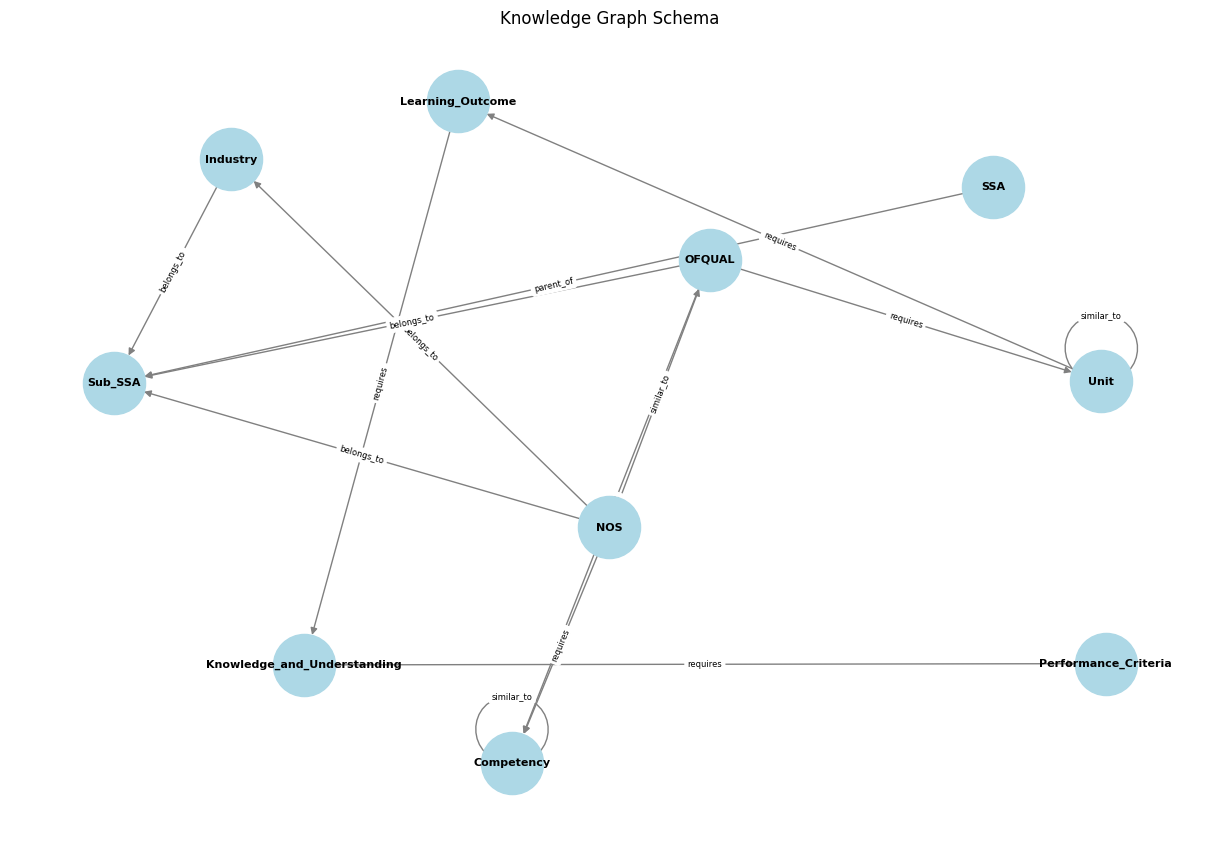

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

# Create directed graph
G = nx.DiGraph()

# Add nodes for each node type
for node_type, attributes in node_types.items():
    G.add_node(node_type)

# Add edges from edge_types
for edge in edge_types:
    source, relation, target = edge
    G.add_edge(source, target, relation=relation)

# Set up the plot
plt.figure(figsize=(12, 8))

# Draw the network
pos = nx.spring_layout(G, k=2, iterations=50)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=2000, font_size=8, font_weight='bold',
        arrows=True, edge_color='gray')

# Add edge labels
edge_labels = {(source, target): data['relation'] 
               for source, target, data in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)

plt.title("Knowledge Graph Schema")
plt.axis('off')
plt.show()

Ok so for the above we now need to focusin on our data preprocessing to allow us to build our graph, normally I try to work throughn dictionary keys as much as possible, because we have some matching that needs, to happen. We are probably going to need to just take a beat and go slow here. 

I went with PyG for this because I know it best then also GDL is now depreciated lol, but if you have used torch before this is veery similar but optimised for graph data, the RGCN works by having both node types (NOS, OFQUAL, SSA etc.) and edge types (belongs_to, requires, similar_to etc.) this gives us the ability to essentially assign a definition and then see how it reacts, 

look at https://www.youtube.com/watch?v=OI0Jo-5d190&list=PLSgGvve8UweGx4_6hhrF3n4wpHf_RV76_ (This was my intro to GNNs)


The RGCN model can handle:
1. Multiple node types (NOS, OFQUAL, SSA etc.)
2. Multiple edge types (belongs_to, requires, similar_to etc.) 
3. Message passing between different types of nodes

This makes it ideal for:
- Analysing relationships between entities (like Social Network Analysis)
- Predicting properties of nodes based on their neighborhood structure and connections e.g our relation to nos and ofqual competencies
- Learning embeddings that capture the semantic relationships in our heterogeneous graph

Preprocessing next steps:
- Break down our Sub_SSA and Industry matches into a smaller list of industries
- Process these smaller lists of industries to find the best match for our NOS & OFQUAL competencies
- build these smaller lists into batches that we can then use to process and link our competentcies too
- build a markscheme for the matching 0-1 with match types and a confidence score.






In [7]:
import dataclasses
from dataclasses import dataclass
from typing import Dict

@dataclass
class ModelConfig:
    in_dim: Dict[str, int]
    h_dim: int
    out_dim: int
    num_rels: int
    num_bases: int

# Note that I used a dataclass decorator to store this because it is a bit more readable and easier to manage, 
# but it is not required for the model to work.
# also the fact that it just orders does all the __init__ work for me is great.

In [4]:
import torch
import torch.nn as nn
from torch_geometric.nn import RGCNConv
from torch_geometric.nn import TransformerConv

class RGCN(nn.Module):
    """
    Relational Graph Convolutional Network for processing multi-relational graphs.
    
    Key Components:
    - Multiple node types (NOS, OFQUAL, SSA, etc.)
    - RGCN layers for message passing
    - Transformer attention for node relationships
    - Cosine similarity scoring
    """
    def __init__(self, in_dim, h_dim, out_dim, num_rels, num_bases=-1): 
        super(RGCN, self).__init__()
        # num_bases is the number of bases to use for the RGCN layers, if -1 is used then it will use all the bases
        # in_dim is the dimension of the input features
        # h_dim is the dimension of the hidden features
        # out_dim is the dimension of the output features
        # num_rels is the number of relations in the graph
        

        # Input layer -> this is where we define our node types and then embed it.
        self.embedding = nn.ModuleDict({
            'NOS': nn.Linear(in_dim['NOS'], h_dim),
            'OFQUAL': nn.Linear(in_dim['OFQUAL'], h_dim),
            'SSA': nn.Linear(in_dim['SSA'], h_dim),
            'Sub_SSA': nn.Linear(in_dim['Sub_SSA'], h_dim),
            'Unit': nn.Linear(in_dim['Unit'], h_dim),
            'Learning_Outcome': nn.Linear(in_dim['Learning_Outcome'], h_dim),
            'Performance_Criteria': nn.Linear(in_dim['Performance_Criteria'], h_dim),
            'Knowledge_and_Understanding': nn.Linear(in_dim['Knowledge_and_Understanding'], h_dim),
            'Industry': nn.Linear(in_dim['Industry'], h_dim),
            'Competency': nn.Linear(in_dim['Competency'], h_dim)
        })
        
        # RGCN layers using PyG -> this is where we define the number of layers (convolutions specifically)
        self.layers = nn.ModuleList([
            RGCNConv(h_dim, h_dim, num_relations=num_rels, num_bases=num_bases)
            for _ in range(2)
        ])
        
        # Transformer layer for attention
        self.attention = TransformerConv(h_dim, h_dim)
        
        # Output projection
        self.output = nn.Linear(h_dim, out_dim)  
        # Our output dimension for our embeddings, normally mismatch here causes a good amount of bug fixing
        
        # Similarity scorer using cosine similarity in the output dimension to allow us to better track the output similarity
        self.similarity = nn.CosineSimilarity(dim=out_dim)


    def forward(self, x, edge_index, edge_type):
        # Embed different node types
        h = {
            ntype: self.embedding[ntype](feat)
            for ntype, feat in x.items()
        }
        
        # Combine embeddings -> This is because due to the complexity of the graph there will likely be multiple nodes of different shapes,
        # so we need to combine them into a single tensor to maintain order in our dictionary essentially this is our preprocessing
        # because our RGCN expects a single tensor.
        h_combined = torch.cat([h[ntype] for ntype in h.keys()], dim=0)
        
        # Apply RGCN layers
        # This is where we apply the RGCN layers to our combined embeddings, this is where the magic happens!
        for layer in self.layers:
            h_combined = layer(h_combined, edge_index, edge_type)
            h_combined = torch.relu(h_combined)
        
        # Apply attention
        # This is essentially where we look at the relationship between the nodes, it does this by taking each node and having a look at its neighbours,
        # Then it will calulate the attention scores (how important is each neightbour), and normalise this, the transformer conv uses softmax i think, 
        # so it just takes the whole thing and turns it into a probability distribution over the neighbours, then this gives us the normalised attention scores
        # that tell us the relationship between 0 and 1 e.g 0.8 strong relationship, 0.3 weak relationship.
        h_combined = self.attention(h_combined, edge_index)
        
        # Output projection
        # Then we take our attention scores and pass them through out output layer to get the final embeddings, which we can then decode. simples
        out = self.output(h_combined)
        
        return out

    def score_similarity(self, h1, h2):
        return self.similarity(h1, h2)